In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Dense,Flatten,Conv2D,BatchNormalization,MaxPooling2D,GlobalAveragePooling2D,Input,Activation,Concatenate,Lambda, \
Add,Dropout,Softmax, PReLU,add
from tensorflow.keras.models import Model
import os
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class Face_detection():

    class StageStatus(object):
        def __init__(self, pad_result: tuple = None, width=0, height=0):
            self.width = width
            self.height = height
            self.x = self.y = self.endx = self.endy = self.offset_x = self.offset_y = self.offset_endx = self.offset_endy = self.tmpw = self.tmph = []
            if pad_result is not None:
                self.update(pad_result)

        def update(self,pad_result):
            self.x, self.y, self.endx, self.endy, self.offset_x, self.offset_y, self.offset_endx, self.offset_endy, self.tmpw, self.tmph = pad_result

    class myMTCNN(object):
        def __init__(self,min_face_size:int = 20,scale_factor:float = 0.709,threshold : list = None,weight_file=None):
            self.min_face_size = min_face_size
            self.scale_factor = scale_factor
            if threshold is None:
                threshold = [0.6,0.7,0.7]
            self.threshold = threshold
            self.p_net,self.r_net,self.o_net = self.__build_pro_network(weight_file)

        @staticmethod
        def __build_p_network(input_shape = None):
            if input_shape is None:
                input_shape = (None,None,3)
            p_inp = Input(input_shape)
            p_net = Conv2D(10,(3,3),(1,1),'valid')(p_inp)
            p_net = PReLU(shared_axes=[1,2])(p_net)
            p_net = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(p_net)
            p_net = Conv2D(16,(3,3),(1,1),'valid')(p_net)
            p_net = PReLU(shared_axes= [1,2])(p_net)
            p_net = Conv2D(32,(3,3),(1,1),'valid')(p_net)
            p_net = PReLU(shared_axes= [1,2])(p_net)
            p_out_1 = Conv2D(2,(1,1),(1,1),'valid')(p_net)
            p_out_1 = Softmax(axis=3)(p_out_1)
            p_out_2 = Conv2D(4,(1,1),(1,1),'valid')(p_net)

            model = Model(p_inp,[p_out_2,p_out_1])
            return model


        @staticmethod
        def __build_r_network(input_shape = None):
            if input_shape is None:
                input_shape = (24,24,3)
            r_inp = Input(input_shape)
            r_net = Conv2D(28,(3,3),(1,1),'valid')(r_inp)
            r_net = PReLU(shared_axes=[1,2])(r_net)
            r_net = MaxPooling2D((3,3),(2,2),'same')(r_net)

            r_net = Conv2D(48,(3,3),(1,1),'valid')(r_net)
            r_net = PReLU(shared_axes=[1,2])(r_net)
            r_net = MaxPooling2D((3,3),(2,2),'valid')(r_net)

            r_net = Conv2D(64,(2,2),(1,1),'valid')(r_net)
            r_net = PReLU(shared_axes=[1,2])(r_net)
            r_net = Flatten()(r_net)
            r_net = Dense(128)(r_net)
            r_net = PReLU()(r_net)
            r_out_1 = Dense(2)(r_net)
            r_out_1 = Softmax(axis=1)(r_out_1)
            r_out_2 = Dense(4)(r_net)
            model = Model(r_inp,[r_out_2,r_out_1])
            return model


        @staticmethod
        def __build_o_network(input_shape = None):
            if input_shape is None:
                input_shape = (48,48,3)

            o_inp = Input(input_shape)
            o_net = Conv2D(32,(3,3),(1,1),'valid')(o_inp)
            o_net = PReLU(shared_axes=[1,2])(o_net)
            o_net = MaxPooling2D((3,3),(2,2),'same')(o_net)
            o_net = Conv2D(64,(3,3),(1,1),'valid')(o_net)
            o_net = PReLU(shared_axes=[1,2])(o_net)
            o_net = MaxPooling2D((3,3),(2,2),'valid')(o_net)
            o_net = Conv2D(64,(3,3),(1,1),'valid')(o_net)
            o_net = PReLU(shared_axes=[1,2])(o_net)
            o_net = MaxPooling2D((2,2),(2,2),'same')(o_net)
            o_net = Conv2D(128,(2,2),(1,1),'valid')(o_net)
            o_net = PReLU(shared_axes=[1,2])(o_net)
            o_net = Flatten()(o_net)
            o_net = Dense(256)(o_net)
            o_net = PReLU()(o_net)
            o_out_1 = Dense(2)(o_net)
            o_out_1 = Softmax(axis=1)(o_out_1)
            o_out_2 = Dense(4)(o_net)
            o_out_3 = Dense(10)(o_net)
            model = Model(o_inp,[o_out_2,o_out_3,o_out_1])

            return model

        @staticmethod
        def __build_pro_network(file = None):
            p_net = Face_detection.myMTCNN.__build_p_network()
            r_net = Face_detection.myMTCNN.__build_r_network()
            o_net = Face_detection.myMTCNN.__build_o_network()
            if(file != None):
                weights = np.load(file, allow_pickle=True).tolist()
                p_net.set_weights(weights['pnet'])
                r_net.set_weights(weights['rnet'])
                o_net.set_weights(weights['onet'])
            return p_net,r_net,o_net



        def __create_scale_pyramid(self,m,min_layer):
            scales = []
            count = 0
            while min_layer >= 12 :
                scales += [m * np.power(self.scale_factor,count)]
                min_layer *= self.scale_factor
                count += 1
            return scales

        @staticmethod
        def __scale_image(img,scale):
            width = int (np.ceil(scale * img.shape[1]))
            height = int (np.ceil(scale * img.shape[0]))
            img = cv2.resize(img,(width,height),interpolation=cv2.INTER_AREA)
            img = (img - 127.5) * 0.0078125
            return img


        @staticmethod
        def __generate_bounding_box(imap,scale,reg,threshold):
            dx1 = reg[:,:,0]
            dy1 = reg[:,:,1]
            dx2 = reg[:,:,2]
            dy2 = reg[:,:,3]

            y, x = np.where(imap >= threshold)

            if y.shape[0] == 1:
         #       print("flipud")
                dx1 = np.flipud(dx1)
                dy1 = np.flipud(dy1)
                dx2 = np.flipud(dx2)
                dy2 = np.flipud(dy2)

            score = imap[(y,x)]
            reg = np.vstack([dx1[(y,x)], dy1[(y,x)], dx2[(y,x)], dy2[(y,x)]])
            reg = np.transpose(reg)

    ##############################################
            if reg.size == 0:
                reg = np.empty(shape=(0, 3))

            strides = 2
            cellsize = 12
            bb = np.transpose(np.vstack([x,y]))
            qs = np.fix((bb * strides + 1) / scale)
            qe = np.fix((bb * strides + cellsize)/scale)

            bounding_boxes = np.hstack([qs,qe,np.expand_dims(score,1),reg])
            return bounding_boxes,reg

        @staticmethod
        def __non_max_supression(boxes,threshold,method):
            if boxes.size == 0:
                return np.empty((0, 3))
            upper_left_x = boxes[:,0]
            upper_left_y = boxes[:,1]
            down_right_x = boxes[:,2]
            down_right_y = boxes[:,3]
            scores = boxes[:,4]
            area_of_all_boxes = (down_right_x - upper_left_x + 1) * (down_right_y - upper_left_y + 1)
            sorted_index = np.argsort(scores)

            count = 0
            pick = np.zeros_like(scores,dtype = np.int16)

            while sorted_index.size > 0:

                max_score_box_index = sorted_index[-1]
                pick[count] = max_score_box_index
                count += 1
                other_boxes_index = sorted_index[0:-1]

                intersection_upper_left_x = np.maximum(upper_left_x[other_boxes_index],upper_left_x[max_score_box_index])
                intersection_upper_left_y = np.maximum(upper_left_y[other_boxes_index],upper_left_y[max_score_box_index])
                intersection_down_right_x = np.minimum(down_right_x[other_boxes_index],down_right_x[max_score_box_index])
                intersection_down_right_y = np.minimum(down_right_y[other_boxes_index],down_right_y[max_score_box_index])

                intersection_box_h = np.maximum(0.0,intersection_down_right_y-intersection_upper_left_y+1)
                intersection_box_w = np.maximum(0.0,intersection_down_right_x-intersection_upper_left_x+1)

                area = intersection_box_h * intersection_box_w

                if method is 'Union':
                    o = area / (area_of_all_boxes[other_boxes_index] + area_of_all_boxes[max_score_box_index] - area)
                else:
                    o = area / np.minimum(area_of_all_boxes[other_boxes_index],area_of_all_boxes[max_score_box_index])

                remaining_ones_index = np.where(o <= threshold)
                sorted_index = sorted_index[remaining_ones_index]

            pick = pick[0:count]
            return pick

        @staticmethod
        def __to_square(box):
            width = box[:,2] - box[:,0]
            height = box[:,3] - box[:,1]
            mx = np.maximum(width,height)
            box[:,0] = box[:,0] + 0.5 * (width - mx)
            box[:,1] = box[:,1] + 0.5 * (height - mx)
            box[:,2:4] = box[:,0:2] + np.transpose(np.tile(mx,(2,1)))
            return box

        @staticmethod
        def __padding(boxes,w,h):
            number_of_boxes = boxes.shape[0]
            tmpw = (boxes[:,2] - boxes[:,0] + 1).astype(np.int32)
            tmph = (boxes[:,3] - boxes[:,1] + 1).astype(np.int32)
            x = boxes[:,0].copy().astype(np.int32)
            y = boxes[:,1].copy().astype(np.int32)
            endx = boxes[:,2].copy().astype(np.int32)
            endy = boxes[:,3].copy().astype(np.int32)
            offset_x = np.ones(number_of_boxes,dtype = np.int32)
            offset_y = np.ones(number_of_boxes,dtype = np.int32)
            offset_endx = tmpw.copy().astype(np.int32)
            offset_endy = tmph.copy().astype(np.int32)

            tmp = np.where(endx > w)
            offset_endx[tmp] = tmpw[tmp] - (endx[tmp] - w)
            endx[tmp] = w

            tmp = np.where(endy > h)
            offset_endy[tmp] = tmph[tmp] - (endy[tmp] - h)
            endy[tmp] = h

            tmp = np.where(x < 1)
            offset_x[tmp] = 2 - x[tmp]
            x[tmp] = 1

            tmp = np.where(y < 1)
            offset_y[tmp] = 2 - y[tmp]
            y[tmp] = 1

            return x,y,endx,endy,offset_x,offset_y,offset_endx,offset_endy,tmpw,tmph


        def __stage1(self,img,scales,status):
            width = img.shape[1]
            height = img.shape[0]
         #   print("scale ssize : " , len(scales) )
            total_boxes = np.empty((0,9))
            for scale in scales:
                scaled_image = self.__scale_image(img,scale)
                scaled_image = np.expand_dims(scaled_image,0)
                scaled_image = np.transpose(scaled_image,(0,2,1,3))
          #      print("scaled image shape ", scaled_image.shape)
                p_predict = self.p_net.predict(scaled_image)
                probs = p_predict[1]
                boxes = p_predict[0]
                probs = np.transpose(probs,(0,2,1,3))
                boxes = np.transpose(boxes,(0,2,1,3))
                bounding_boxes, regression = self.__generate_bounding_box(probs[0,:,:,1].copy(),scale,boxes[0,:,:,:].copy(),self.threshold[0])
                pick = self.__non_max_supression(bounding_boxes.copy(),0.5,'Union')
                if bounding_boxes.size > 0 and pick.size > 0 :
                    bounding_boxes = bounding_boxes[pick,:]
                    total_boxes = np.append(total_boxes,bounding_boxes,axis = 0)

            number_of_boxes = total_boxes.shape[0]
         #   print("number of boxes : " , number_of_boxes)
            if number_of_boxes > 0:
                pick = self.__non_max_supression(total_boxes.copy(),0.7,'Union')
                boxes = total_boxes[pick,:]

                boxes_h = boxes[:,3] - boxes[:,1]
                boxes_w = boxes[:,2] - boxes[:,0]
                actual_left_x = boxes[:,0] + boxes_w * boxes[:,5]
                actual_left_y = boxes[:,1] + boxes_h * boxes[:,6]
                actual_right_x = boxes[:,2] + boxes_w * boxes[:,7]
                actual_right_y = boxes[:,3] + boxes_h * boxes[:,8]
                boxes = np.transpose(np.vstack([actual_left_x,actual_left_y,actual_right_x,actual_right_y,boxes[:,4]]))
           #     print("total boxes : " , boxes.shape)
                boxes = self.__to_square(boxes.copy())
                boxes[:,0:4] = np.fix(boxes[:, 0:4]).astype(np.int32)
                status = Face_detection.StageStatus(self.__padding(boxes.copy(),width,height),width,height)
                return boxes,status


        def __stage2(self,img,boxes,status):
            num_boxes = boxes.shape[0]
            tmp_image = np.zeros((num_boxes,24,24,3))
            for i in range(0,num_boxes):
            #    print(status.endy[i]-status.y[i]-1)
                padded_image = np.zeros((int(status.tmph[i]),int(status.tmpw[i]),3))
                padded_image[status.offset_y[i]-1:status.offset_endy[i],status.offset_x[i]-1:status.offset_endx[i],:] = \
                img[status.y[i]-1:status.endy[i],status.x[i]-1:status.endx[i],:]
                if padded_image.shape[0] > 0 and padded_image.shape[1] > 0 or padded_image.shape[0] == 0 and padded_image.shape[1] == 0:
                    tmp_image[i,:,:,:] = cv2.resize(padded_image,(24,24),interpolation = cv2.INTER_AREA)
                else:
                    print("return from stage2")

            tmp_image = (tmp_image - 127.5) * 0.0078125
            tmp_image = np.transpose(tmp_image,(0,2,1,3))
            rOut = self.r_net.predict(tmp_image)
            probs = rOut[1]
            reg = rOut[0]
        #    print("reg shape : ",reg.shape)
            scores = probs[:,1]

            index = np.where(scores > self.threshold[1])

            boxes = np.hstack([boxes[index[0],0:4].copy(),np.expand_dims(scores[index[0]].copy(),1)])   ################
            reg = reg[index[0],:]

            if boxes.shape[0] > 0:
                pick = self.__non_max_supression(boxes,0.7,'Union')
                boxes = boxes[pick,:]
                boxes = self.__calibrate(boxes.copy(),reg[pick,0:4])
                boxes = self.__to_square(boxes.copy())
                boxes = np.fix(boxes).astype(np.int32)
                status = Face_detection.StageStatus(self.__padding(boxes,status.width,status.height),status.width,status.height)

            return boxes,status


        def __stage3(self,img,boxes,status):
            num_boxes = boxes.shape[0]
            if num_boxes == 0 :
                return boxes,np.empty(shape=(0,))
            tmp_image = np.zeros((num_boxes,48,48,3))

            for i in range(0,num_boxes):
                padded_image = np.zeros((int(status.tmph[i]),int(status.tmpw[i]),3))
                padded_image[status.offset_y[i]-1:status.offset_endy[i],status.offset_x[i]-1:status.offset_endx[i],:] = \
                img[status.y[i]-1:status.endy[i],status.x[i]-1:status.endx[i],:]
                if padded_image.shape[0] > 0 and padded_image.shape[1] > 0 or padded_image.shape[0] == 0 and padded_image.shape[1] == 0:
                    tmp_image[i,:,:,:] = cv2.resize(padded_image,(48,48),interpolation = cv2.INTER_AREA)
                else:
                    print("return from stage2")

            tmp_image = (tmp_image - 127.5) * 0.0078125
            tmp_image = np.transpose(tmp_image,(0,2,1,3))
            Oout = self.o_net.predict(tmp_image)
            reg = Oout[0]
            points = Oout[1]
            probs = Oout[2]
            score = probs[:,1]
            index = np.where(score > self.threshold[2])
            boxes = np.hstack([boxes[index[0],0:4].copy(),np.expand_dims(score[index[0]].copy(),1)])
            if boxes.shape[0] > 0:
                boxes = self.__calibrate(boxes.copy(),reg[index[0],:])
                pick = self.__non_max_supression(boxes,.7,'Min')
                boxes = boxes[pick,:]
                points = points[pick,:]

            return boxes,points

        @staticmethod
        def __calibrate(boxes,reg):
            ##############################################
            w = boxes[:,2] - boxes[:,0] + 1
            h = boxes[:,3] - boxes[:,1] + 1
            #############################################
            boxes[:,0] = boxes[:,0] + reg[:,0] * w
            boxes[:,1] = boxes[:,1] + reg[:,1] * h
            boxes[:,2] = boxes[:,2] + reg[:,2] * w
            boxes[:,3] = boxes[:,3] + reg[:,3] * h

            return boxes



        def detect_faces(self,img):
            height, width, _ = img.shape
            m = 12 / self.min_face_size
            min_layer = m * min(width,height)
            scales = self.__create_scale_pyramid(m,min_layer)
            status = Face_detection.StageStatus(width = width,height = height)
            boxes, status =  self.__stage1(img,scales,status)
            boxes,status = self.__stage2(img,boxes,status)
            boxes,points = self.__stage3(img,boxes,status)

            bounding_boxes = []

            for bounding_box,keypoints in zip(boxes,points):
                x = max(0, int(bounding_box[0]))
                y = max(0, int(bounding_box[1]))
                width = int(bounding_box[2] - x)
                height = int(bounding_box[3] - y)
                bounding_boxes.append({
                    'box': [x, y, width, height],
                    'confidence': bounding_box[-1],
                    'keypoints': {
                        'left_eye': (int(keypoints[0]), int(keypoints[5])),
                        'right_eye': (int(keypoints[1]), int(keypoints[6])),
                        'nose': (int(keypoints[2]), int(keypoints[7])),
                        'mouth_left': (int(keypoints[3]), int(keypoints[8])),
                        'mouth_right': (int(keypoints[4]), int(keypoints[9])),
                    }
                })
            return bounding_boxes


    class Facenet():

        @staticmethod
        def scaling(x,scale):
            return x*scale

        @staticmethod
        def __convLayer(x,
                      num_filter,
                      kernel,
                      strides,
                      padding = 'valid',
                      activation = 'relu',
                      use_bias = False):
            x = Conv2D(num_filter,kernel,strides,padding,use_bias=use_bias)(x)
            if use_bias == False:
                x = BatchNormalization(axis = 3,momentum = .995,epsilon = .001,scale = False)(x)
            if activation is not None:
                x = Activation(activation)(x)
            return x

        @staticmethod
        def __stem(x):
            x = Face_detection.Facenet.__convLayer(x,32,3,2)
            x = Face_detection.Facenet.__convLayer(x,32,3,1)
            x = Face_detection.Facenet.__convLayer(x,64,3,1,'same')
            x = MaxPooling2D(pool_size=(3,3),strides=2)(x)
            x = Face_detection.Facenet.__convLayer(x,80,1,1,'same')
            x = Face_detection.Facenet.__convLayer(x,192,3,1)
            x = Face_detection.Facenet.__convLayer(x,256,3,2)

            return x

        @staticmethod
        def __inception_block(x,type,activation='relu',scale=1):
            if type == 'A':
                path1 = Face_detection.Facenet.__convLayer(x,32,1,1,'same')
                path2 = Face_detection.Facenet.__convLayer(x,32,1,1,'same')
                path3 = Face_detection.Facenet.__convLayer(x,32,1,1,'same')
                path2 = Face_detection.Facenet.__convLayer(path2,32,3,1,'same')
                path3 = Face_detection.Facenet.__convLayer(path3,32,3,1,'same')
                path3 = Face_detection.Facenet.__convLayer(path3,32,3,1,'same')
                mixed = Concatenate(axis = 3)([path1,path2,path3])
                mixed = Face_detection.Facenet.__convLayer(mixed,256,1,1,'same',None,True)
                mixed = Lambda(Face_detection.Facenet.scaling,arguments={'scale': scale})(mixed)
                final = add([x,mixed])
                if activation is not None:
                    final = Activation(activation)(final)
                return final

            if type == 'B':
                path1 = Face_detection.Facenet.__convLayer(x,128,1,1,'same')
                path2 = Face_detection.Facenet.__convLayer(x,128,1,1,'same')
                path2 = Face_detection.Facenet.__convLayer(path2,128,[1,7],1,'same')
                path2 = Face_detection.Facenet.__convLayer(path2,128,[7,1],1,'same')
                mixed = Concatenate(axis = 3)([path1,path2])
                mixed = Face_detection.Facenet.__convLayer(mixed,896,1,1,'same',None,True)
                mixed = Lambda(Face_detection.Facenet.scaling,arguments={'scale': scale})(mixed)
                final = add([x,mixed])
                if activation is not None:
                    final = Activation(activation)(final)
                return final

            if type == 'C':
                path1 = Face_detection.Facenet.__convLayer(x,192,1,1,'same')
                path2 = Face_detection.Facenet.__convLayer(x,192,1,1,'same')
                path2 = Face_detection.Facenet.__convLayer(path2,192,(1,3),1,'same')
                path2 = Face_detection.Facenet.__convLayer(path2,192,(3,1),1,'same')
                mixed = Concatenate(axis = 3)([path1,path2])
                mixed = Face_detection.Facenet.__convLayer(mixed,1792,1,1,'same',None,True)
                mixed = Lambda(Face_detection.Facenet.scaling,arguments={'scale': scale})(mixed)
                final = add([x,mixed])
                if activation is not None:
                    final = Activation(activation)(final)
                return final

        @staticmethod
        def __reduction_block(x,type):
            if type == 'A':
                k = 192
                l = 192
                m = 256
                n = 384
                maxPoolBranch = MaxPooling2D((3,3),(2,2),'valid')(x)
                conv_branch1 = Face_detection.Facenet.__convLayer(x,n,3,2,'valid')
                conv_branch2 = Face_detection.Facenet.__convLayer(x,k,1,1,'same')
                conv_branch2 = Face_detection.Facenet.__convLayer(conv_branch2,l,3,1,'same')
                conv_branch2 = Face_detection.Facenet.__convLayer(conv_branch2,m,3,2,'valid')
                concat = Concatenate(axis = 3)([conv_branch1,conv_branch2,maxPoolBranch])

                return concat

            if type == 'B':
                maxPool = MaxPooling2D((3,3),(2,2),'valid')(x)
                conv1 = Face_detection.Facenet.__convLayer(x,256,1,1,'same')
                conv1 = Face_detection.Facenet.__convLayer(conv1,384,3,2,'valid')
                conv2 = Face_detection.Facenet.__convLayer(x,256,1,1,'same')
                conv2 = Face_detection.Facenet.__convLayer(conv2,256,3,2,'valid')
                conv3 = Face_detection.Facenet.__convLayer(x,256,1,1,'same')
                conv3 = Face_detection.Facenet.__convLayer(conv3,256,3,1,'same')
                conv3 = Face_detection.Facenet.__convLayer(conv3,256,3,2,'valid')
                concat = Concatenate(axis = 3)([conv1,conv2,conv3,maxPool])

                return concat
        @staticmethod
        def __inception_resnet_v1(input_shape,classes,weightsFile):
            input_ = Input(input_shape)
            x = Face_detection.Facenet.__stem(input_)
            for i in range(5):
                x = Face_detection.Facenet.__inception_block(x,'A',scale = 0.17)
            x = Face_detection.Facenet.__reduction_block(x,'A')
            for i in range(10):
                x = Face_detection.Facenet.__inception_block(x,'B',scale = 0.1)
            x = Face_detection.Facenet.__reduction_block(x,'B')
            for i in range(5):
                x = Face_detection.Facenet.__inception_block(x,'C',scale=.2)
            ###############?????##################
            x = Face_detection.Facenet.__inception_block(x,'C',activation=None,scale=1.)

            x = GlobalAveragePooling2D()(x)
            x = Dropout(.2)(x)
            x = Flatten()(x)
            x = Dense(classes,use_bias=False)(x)
            x = BatchNormalization(momentum=.995,epsilon=.001,scale=False)(x)
            model = Model(input_,x)
            optimizer = tf.keras.optimizers.SGD(learning_rate = .001,momentum = .9)
            if weightsFile is not None:
                model.load_weights(weightsFile)

            return model


        def __init__(self,out_dim = 128,input_shape=(160,160,3),weight_file=None):
            self.out_dim = out_dim
            self.input_shape = input_shape
            self.weight_file = weight_file

        def create_model(self):
            model = self.__inception_resnet_v1(self.input_shape,self.out_dim,self.weight_file)
            return model


    def __init__(self,mtcnn_weights_file=None,facenet_weights=None,min_face_size = 20):
        self.mtcnn = Face_detection.myMTCNN(weight_file = mtcnn_weights,min_face_size=min_face_size)
        self.encoder = Face_detection.Facenet(weight_file = facenet_weights).create_model()
        self.x = None
        self.y = None

    def compile_model(self,optimizer=None,loss=None,loss_margin = .5):
        if optimizer == None:
            optimizer = tf.keras.optimizers.SGD(learning_rate = .001,momentum=.9)
        if loss == 'batch_all_triplet_loss':
            loss = self.__batch_all_triplet_loss
        elif loss == 'batch_hard_triplet_loss':
            loss = self.__batch_hard_triplet_loss
        else:
            loss = self.__batch_all_triplet_loss

        self.loss = loss
        self.loss_margin = loss_margin
        self.encoder.compile(optimizer=optimizer,loss=self.triplet_loss)

    def fit(self,x,y,batch_size,epochs,callbacks,datagen):
        self.y = y
        hist = []
        datagen.fit(x)
        if(callbacks != None):
            hist = self.encoder.fit(datagen.flow(x,y,batch_size = batch_size),epochs = epochs,callbacks = callbacks)
        else:
            hist = self.encoder.fit(datagen.flow(x,y,batch_size = batch_size),epochs = epochs)
        print("predicting after training")
        self.x = self.encoder.predict(x)
        return hist

    def predict(self,x):
        return self.encoder.predict(x)

    def triplet_loss(self,y,y_pred):
        y = tf.argmax(y,axis=1)
        return self.loss(y,y_pred,self.loss_margin)

    @staticmethod
    def __pairwise_distance(embedding,squared=False):
        dot_product = tf.matmul(embedding,tf.transpose(embedding))
        squares = tf.linalg.diag_part(dot_product)
        distance = tf.expand_dims(squares,1) - dot_product + tf.expand_dims(squares,0)
        distance = tf.maximum(distance,0.0)
        if not squared:
            mask = tf.equal(distance,0.0)
            mask = tf.cast(mask,dtype=tf.float32)
            distance = distance + mask * 1e-16
            distance = tf.sqrt(distance)
            distance = distance * (1.0 - mask)
        return distance

    @staticmethod
    def __positive_mask(labels):
        diagonal = tf.cast(tf.eye(tf.shape(labels)[0]),dtype=tf.bool)
        all_except_diagonal = tf.logical_not(diagonal)
        equals = tf.equal(tf.expand_dims(labels,0),tf.expand_dims(labels,1))
        mask = tf.logical_and(all_except_diagonal,equals)
        return mask

    @staticmethod
    def __negative_mask(labels):
        equals = tf.equal(tf.expand_dims(labels,0),tf.expand_dims(labels,1))
        mask = tf.logical_not(equals)
        return mask

    @staticmethod
    def __triplet_mask(labels):
        indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]),dtype = tf.bool)
        indices_not_equal = tf.logical_not(indices_equal)
        i_not_equal_j = tf.expand_dims(indices_not_equal,2)
        i_not_equal_k = tf.expand_dims(indices_not_equal,1)
        j_not_equal_k = tf.expand_dims(indices_not_equal,0)

        distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j,i_not_equal_k),j_not_equal_k)

        label_equal = tf.equal(tf.expand_dims(labels,0),tf.expand_dims(labels,1))
        i_equal_j = tf.expand_dims(label_equal,2)
        i_equal_k = tf.expand_dims(label_equal,1)
        valid_labels = tf.logical_and(i_equal_j,tf.logical_not(i_equal_k))
        mask = tf.logical_and(valid_labels,distinct_indices)

        return mask

    @staticmethod
    def __batch_all_triplet_loss(labels,embeddings,margin,squared=False):
        pairwise_distance = Face_detection.__pairwise_distance(embeddings)

        positives = tf.expand_dims(pairwise_distance,2)
        negatives = tf.expand_dims(pairwise_distance,1)

        triplet_loss = positives - negatives + margin

        mask = Face_detection.__triplet_mask(labels)
        mask = tf.cast(mask,dtype=tf.float32)

        triplet_loss = tf.multiply (triplet_loss,mask)
        triplet_loss = tf.maximum(triplet_loss,0.0)

        positive_triplet = tf.cast(tf.greater(triplet_loss,1e-16),dtype=tf.float32)
        num_positive_triplet = tf.reduce_sum(positive_triplet)
        triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplet + 1e-16)
        return triplet_loss


    @staticmethod
    def __batch_hard_triplet_loss(labels,embeddings,margin,squared=False):
        pairwise_distance = Face_detection.__pairwise_distance(embeddings,squared)

        positives = Face_detection.__positive_mask(labels)
        positives = tf.cast(positives,dtype=tf.float32)

        positive_dist = tf.multiply(positives,pairwise_distance)

        hardest_positive_dist = tf.reduce_max(positive_dist,axis=1,keepdims=True)

        negatives = Face_detection.__negative_mask(labels)
        negatives = tf.cast(negatives,dtype=tf.float32)

        negative_dist = tf.reduce_max(pairwise_distance,axis=1,keepdims=True)
        negative_dist = pairwise_distance + negative_dist * (1.0 - negatives)

        hardest_negative_dist = tf.reduce_min(negative_dist,axis=1,keepdims=True)

        triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin,0.0)
        triplet_loss = tf.reduce_mean(triplet_loss)

        return triplet_loss

    def generate_from_dir(self,root_dir,src,batch_size,epochs,datagen,callbacks=None):
        self.src = src
        classes = len(src)
        faces = []
        labels = []
        j = 0
        for cls in src:
            c = 0
            path = root_dir + '/' + cls
            image_files = os.listdir(path)
            for file in image_files:
                face = plt.imread(path + '/' + file)
                mn,std = face.mean(),face.std()
                face = (face - mn) / std
                faces += [np.expand_dims(face,axis=0)]
                c += 1
            class_label = np.full((c,classes),0)
            class_label[:,j] = 1
            labels += [class_label]
            j += 1

        x = np.concatenate(faces)
        y = np.concatenate(labels)
        return self.fit(x,y,batch_size,epochs,callbacks,datagen)

    def detect_faces(self,src,isdir,show_faces=True,return_boxes=False):
        image_files = []
        if not isdir:
            image_files += [src]
        else:
            image_files = os.listdir(src)
            image_files = [src + '/' + image_file for image_file in image_files]

        faces = []
        boxes = []
        for image_file in image_files:
            image_array = plt.imread(image_file)
            boxes = self.mtcnn.detect_faces(image_array)
            for box in boxes:
                x,y,w,h = box['box']
                if(x >= image_array.shape[1] or y >= image_array.shape[0]):
                    continue
                x1 = x
                y1 = y
                x2 = min(x+w,image_array.shape[1])
                y2 = min(y+h,image_array.shape[0])
                if(x1 >= x2 or y1 >= y2):
                    continue
                tempimg = image_array[y1:y2,x1:x2,:]
                tempimg = cv2.resize(tempimg,(160,160),interpolation=cv2.INTER_AREA)
                faces += [tempimg]
                if(show_faces):
                    plt.imshow(tempimg)
                    plt.show()

        if return_boxes :
            return faces, boxes
        return faces

    def predict(self,src,show_image,show_faces = False,divider=150,font=None,save_path = None,bottom_thres=9,upper_thres = 11):
        image = Image.open(src)
        draw = ImageDraw.Draw(image)
        faces,boxes = self.detect_faces(src,isdir=False,show_faces=False,return_boxes=True)
#         faces = [np.expand_dims(face,axis=0) for face in faces]
        normalized = []
        for face in faces:
            if(show_faces):
                plt.imshow(face)
                plt.show()
            normalized += [np.expand_dims((face - face.mean())/face.std(),axis=0)]
        x = np.concatenate(normalized)
        pred = self.encoder.predict(x)
        if font == None:
            font = "/content/drive/My Drive/datasets_81753_300187_futur (1).ttf"

        font = ImageFont.truetype(font=font
                                  ,size=(image.size[0] + image.size[1]) // divider)
        for i in range(pred.shape[0]):
            x,y,w,h = boxes[i]['box']
            x1 = x
            y1 = y
            x2 = x1 + w
            y2 = y1 + h
            print("w and h : ",w,h)
            thickness = 5
            for t in np.linspace(0, 1, thickness):
                x1,y1 = x1 + t,y1 + t
                x2,y2 = x2 - t, y2 - t
                draw.rectangle([x1,y1,x2,y2], outline=(255,0,0))
            embedding = np.expand_dims(pred[i,:],axis=0)
            diff = self.x - embedding
            diff = np.linalg.norm(diff,axis = 1)
            mn = np.amin(diff)
            mni = np.argmin(diff,axis=0)
            print(self.src[np.argmax(self.y[mni])])
            label = self.src[np.argmax(self.y[mni])]
            if(mn >= upper_thres):
                label = "not_registered"
            if(mn > bottom_thres and mn < upper_thres ):
                label += " low conf."
            text = '{} {:.1f}'.format(label,mn)
            text_size = draw.textsize(text, font=font)
            draw.rectangle(
                [x1, y1 - text_size[1], x1 + text_size[0], y1],
                fill=(255,0,0))
            draw.text((x1, y1 - text_size[1]), text, fill='black',
                      font=font)

        if(save_path != None):
            image.save(save_path)
        display(image)

In [ ]:
mtcnn_weights = '/content/drive/My Drive/mtcnn_weights.npy'
facenet_weights = '/content/drive/My Drive/Copy of facenet_keras_weights.h5'
detect = Face_detection(mtcnn_weights,facenet_weights)

In [ ]:

def extract_zip(source,dest):
  import zipfile
  data = zipfile.ZipFile(source,'r')
  data.extractall(dest)
  data.close()

# extract_zip('/content/drive/My Drive/faces only.zip','/content/drive/My Drive')
# extract_zip('/content/drive/My Drive/faces only 2.zip','/content/drive/My Drive')
extract_zip('/content/both.zip','/content')

In [ ]:
def scheduler(epoch):
    lr = .001
    c = epoch // 200
    lr = lr / (10 ** c)
    return lr

epochs = 0
margin = 4
lr = .01
batch_size = 128

datagen = ImageDataGenerator(rotation_range=20,horizontal_flip=True)

opt = tf.keras.optimizers.SGD(learning_rate = lr,momentum=.9)
# opt = tf.keras.optimizers.Adam(learning_rate = .001)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 2)
detect.compile_model(loss_margin= margin,loss = 'batch_all_triplet_loss',optimizer=opt)
history = detect.generate_from_dir('/content/both/faces only 2',
                         ['quvi','ratul','toki','tamim','haider','limon','rumi','akib','ananto','shezan','babu_sir',
                         'shamim_vai','ripon_vai','monsur_vai','efran_vai','nafis','tanjeem','mamun','hisham','asif'
                         ,'arman','nayeem','zubair','rakib','samee','sachin','osama','rabib','rakin','kamal',
                         'jamil','sakib','zeon','dip','arup','jinan','maruf','somonindro',
                         'masum','sabit','sajib','raju','ainan','abdullah','rafsan','rakin-gr-3','rashed','suhan','sourav',
                        'younib','chayon','mahin','nahian','aditya'],batch_size,epochs,datagen)

predicting after training


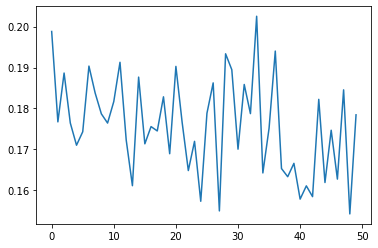

In [ ]:
 plt.plot(history.history['loss'])

In [ ]:
path = []

path += ['/content/drive/MyDrive/20190515_122107 (1).jpg']

i = 0
for path in path:
    detect.predict(path,True,False,bottom_thres=9,upper_thres=10,
                   save_path="/content/result"+ str(i) + ".jpg",divider = 400)
    i += 1

In [ ]:
src =   ['quvi','ratul','toki','tamim','haider','limon','rumi','akib','ananto','shezan','babu_sir',
                         'shamim_vai','ripon_vai','monsur_vai','efran_vai','nafis','tanjeem','mamun','hisham','asif'
                         ,'arman','nayeem','zubair','rakib','samee','sachin','osama','rabib','rakin','kamal',
                         'jamil','sakib','zeon','dip','arup','jinan','maruf','somonindro',
                         'masum','sabit','sajib','raju','ainan','abdullah','rafsan','rakin-gr-3','rashed','suhan','sourav',
                          'younib','chayon','mahin','nahian','aditya']

test_folders =  ['quvi','ratul','toki','tamim','haider','limon','rumi','akib','ananto','shezan','babu_sir',
                         'shamim_vai','ripon_vai','monsur_vai','efran_vai','nafis','tanjeem','mamun','hisham','asif'
                         ,'arman','nayeem','zubair','rakib','samee','sachin','osama','rabib','rakin','kamal',
                         'jamil','sakib','zeon','dip','arup','jinan','maruf','somonindro',
                         'masum','sabit','sajib','raju','ainan','abdullah','rafsan','rakin-gr-3','rashed','suhan','sourav',
                          'younib','chayon','mahin','nahian','aditya']

# test_folders = ['other']

faces = []
path = "/content/both/faces only"
for folder in test_folders:
    image_files = os.listdir(path + '/' + folder)
    for file in image_files:
        faces += [plt.imread(path + '/' + folder + '/' + file)]
validate = []
for i in range(len(faces)):
    mn,std = faces[i].mean(),faces[i].std()
    validate.append(np.expand_dims((faces[i] - mn) / std,0))

validate = np.concatenate(validate)
print(validate.shape)
validate = detect.encoder.predict(validate)

low_thres = 9
high_thres = 10
below_thres = 0
above_thres = 0
in_between = 0
actually_predicted = 0
act_correctly_predicted = 0
predict_thres = .2

failed_faces = []
failed_values = []
below_faces = []
between_faces = []
below_faces_index = []

mn_all = 1000

all_vals = []

tot = 0
for i in range(validate.shape[0]):

#     plt.imshow(faces[i])
#     plt.show()
    embedding = validate[i,:]
    embedding = np.expand_dims(embedding,0)
    diff = detect.x - embedding
    diff = np.linalg.norm(diff,axis = 1)
    mn = np.amin(diff)
    mni = np.argmin(diff,axis=0)
    print(src[np.argmax(detect.y[mni])])
    if(mn > high_thres):
        above_thres += 1
        failed_faces += [faces[i]]
        failed_values += [mn]
    elif (mn > low_thres):
        in_between += 1
        between_faces += [faces[i]]
    else:
        below_thres += 1
        if(mn > predict_thres):
            below_faces += [faces[i]]
            below_faces_index += [i]
        if(mn > predict_thres):
            act_correctly_predicted += 1
    if(mn > predict_thres):
        actually_predicted += 1

    mn_all = min(mn,mn_all)
    tot += 1
    all_vals += [mn]
#     print(np.argmax(yt[i]))
    print(mn)
print("classes : ",len(src),"\nmargin : ",margin)
print("above Thres : ",above_thres,"\nin between : ",
      in_between,"\nact correct pred : ",act_correctly_predicted,"\nactually predicted : ", actually_predicted
      ,"\nthreshold : (",low_thres," - ",high_thres,")")

print("\nmin value : ", mn_all)

(854, 160, 160, 3)
quvi
0.0
quvi
0.0
quvi
6.428148
quvi
3.3770356
quvi
0.0
quvi
0.0
quvi
0.0
quvi
5.846347
quvi
0.0
quvi
9.780224
quvi
4.9420466
quvi
3.1016347
quvi
0.0
quvi
4.1089067
quvi
0.0
quvi
0.0
ratul
6.5205774
ratul
0.0
ratul
0.0
ratul
7.2402825
ratul
0.0
ratul
0.0
ratul
3.7381048
ratul
0.0
ratul
0.0
ratul
0.0
ratul
10.122067
ratul
0.0
ratul
0.0
ratul
0.0
ratul
0.0
ratul
0.0
ratul
0.0
toki
0.0
toki
6.772453
toki
0.0
toki
0.0
toki
4.1839147
toki
7.688841
toki
0.0
toki
0.0
toki
6.967491
toki
0.0
toki
6.2361584
toki
0.0
toki
0.0
toki
5.7697635
toki
6.1820526
toki
0.0
toki
3.8805285
toki
12.059358
toki
0.0
toki
3.2388432
toki
0.0
toki
7.8063836
toki
0.0
toki
0.0
toki
4.790078
toki
0.0
toki
9.029016
toki
0.0
toki
0.0
toki
5.066302
toki
5.066302
toki
0.0
toki
0.0
toki
0.0
toki
4.0440636
toki
4.123001
tamim
9.678009
tamim
6.0544057
tamim
6.3191547
tamim
0.0
tamim
6.8368
tamim
4.689832
tamim
0.0
tamim
4.907166
tamim
7.8555737
tamim
0.0
tamim
0.0
tamim
0.0
tamim
12.155737
tamim
0.0
tami

In [ ]:
all_vals.sort()
print(all_vals)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from distutils.dir_util import copy_tree
copy_tree("/content/drive/My Drive/faces only", "/content")

In [ ]:
len(src)

25

In [ ]:
def show_faces(faces):
    for face in faces:
        plt.imshow(face)
        plt.show()

# show_faces(failed_faces)
# print(failed_values)

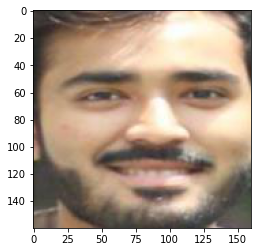

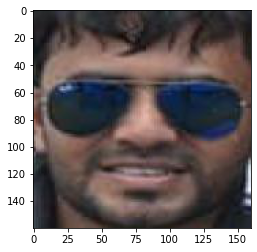

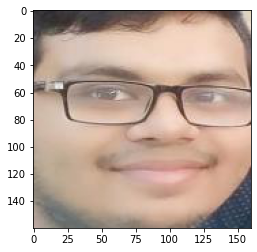

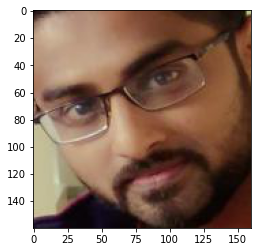

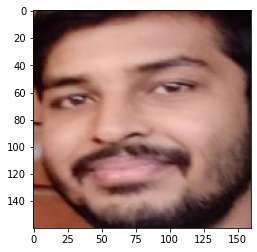

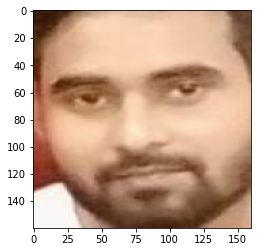

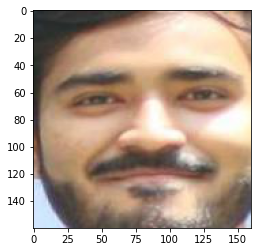

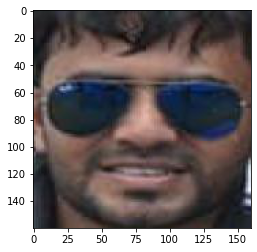

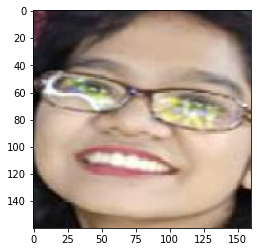

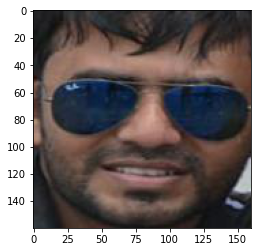

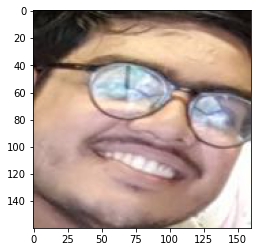

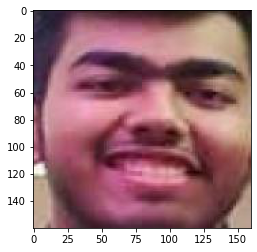

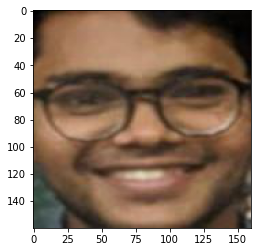

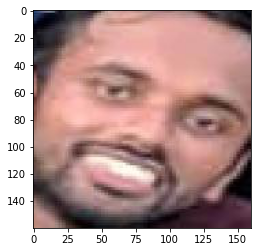

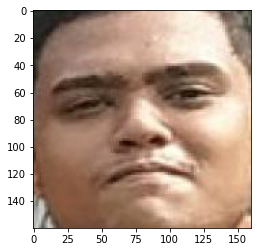

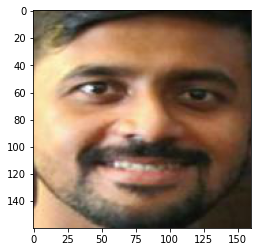

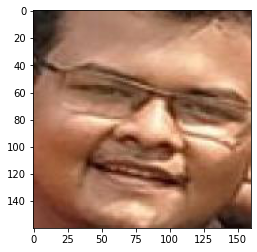

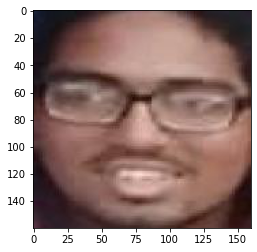

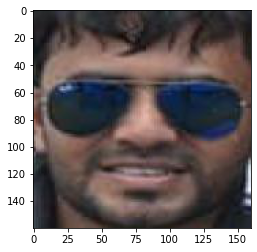

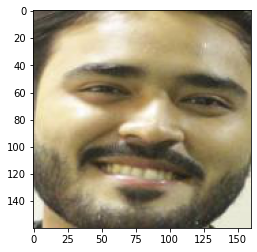

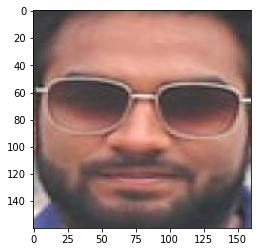

[75, 111, 296, 322, 325, 533, 615, 706, 729, 749, 759, 772, 777, 915, 973, 1098, 1100, 1117, 1260, 1308, 1332]


In [ ]:
show_faces(below_faces)
print(below_faces_index)

In [ ]:
show_faces(between_faces)

In [ ]:
os.listdir('/content/both/faces only/other')[932]

In [ ]:
detect.encoder.save_weights("/content/drive/My Drive/cl-30-mr-4.5-lb-8.5-ub-10-bet-9-corr-153-tot-177-29-07-2020-12-27-am.h5")

In [ ]:
detect.encoder.load_weights("/content/drive/MyDrive/cl-54-mr-4-lb-9-ub-10-bet-18-corr-299-tot-345-02-08-2020-11-30-pm.h5")

In [ ]:
len(src)

def convertString(charArr):
    charArr = list(charArr)
    for i in range(len(charArr)):
        if(charArr[i] == ' ' or charArr[i] == '\n' or charArr[i] == '\t'):
            charArr[i] = '_'

    s = ''.join(charArr)
    return s

s = convertString('''classes :  54
		margin :  4.5
		above Thres :  22
		in between :  24
		act correct pred :  299
		actually predicted :  345
		threshold : ( 8.5  -  9.5 )
		min value : 8.655
		bacth size : 128
		false bet : 15.h5''')



In [ ]:
detect.encoder.save_weights('/content/drive/My Drive/'+s)

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

angles = [20,30,-20,-30]

for folder in src:
    path = "/content/both/faces only 2"
    img_files = os.listdir(path + "/" + folder)
    for img in img_files:
        image = plt.imread(path+"/"+folder+"/"+img)
        for angle in angles:
            rotated_image = rotate_image(image,angle)
            plt.imsave(path+"/"+folder+"/"+str(angle)+img,rotated_image)
            # plt.imshow(rotated_image)
            # plt.show()
    # break

In [ ]:
image = plt.imread('/content/drive/My Drive/20190515_122107 (1).jpg')
image.std()

76.51498946105191

In [ ]:
detect.en

array([[-0.57057136, -0.5365906 ,  0.62649137, ..., -0.94557416,
        -0.05831705, -0.6005044 ],
       [ 0.7262319 , -0.16032642,  0.64184064, ...,  0.901847  ,
         0.78835714, -1.4482472 ],
       [ 1.1586443 , -0.26058605,  0.33473933, ..., -0.6613961 ,
         0.23394807, -1.6990683 ],
       ...,
       [-0.22374256, -0.7389715 , -1.1045461 , ..., -0.45599347,
         0.3049332 , -0.06891949],
       [ 0.72877413, -0.49015367, -1.1973115 , ...,  0.7480056 ,
         0.58331066,  0.72335786],
       [ 0.31347716, -0.5540743 , -1.0531621 , ..., -0.16257304,
         1.2890813 , -0.31546253]], dtype=float32)